# Sentiment Analysis
情感分析可以判断一段话本身的感情色彩是偏积极/正面还是消极/反面，但是描述复杂的语境和立场则有所欠缺。以下面这条微博为例，评论区大部分都是以讽刺和戏谑的语气支持帖子，表达跟帖子一样的不满，因此被判定为消极情感。

In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import json

from social_media_comment_sentiment.data_processing import get_comments_and_replies

model_path="models/roberta-base-dianping"
classifier = pipeline("sentiment-analysis", model=model_path)

print("loaded model")

def clean_text(text: str) -> str:
    return text.strip()

def get_sentiment(classifier,text):
    return classifier(text)

with open("weibo2.json", "r", encoding="utf-8") as f:
    data = json.load(f)


# Put all comments/replies into a list
sentiment_data=data
for c in sentiment_data["comments"]:
    res=get_sentiment(classifier,c["text"])[0]
    c["sent_label"]=res["label"]
    c["sent_score"]=res["score"]
    print(f"{c["text"]}\n{c['sent_label']}: {c['sent_score']}")
    if "replies" in c:
        for r in c["replies"]:
            res = get_sentiment(classifier,r["text"])[0]
            r["sent_label"] = res["label"]
            r["sent_score"] = res["score"]

# print(sentiment_data)
# print(*comments, sep="\n")
# sent_out_path="weibo_example_sentiment.json"
# with open(sent_out_path, "w", encoding="utf-8") as f:
#     json.dump(sentiment_data, f, indent=2, ensure_ascii=False)


Device set to use cpu


loaded model
本来出去吃饭就是不想做饭，结果饭店厨子也不想做饭，只是剪开塑料袋，解冻加热就给你端上来[允悲]
negative (stars 1, 2 and 3): 0.9398384690284729
主要是西贝菜品定价太高，如果老罗说沙县和黄焖鸡是预制菜，大家只会说：不然呢[笑cry]
negative (stars 1, 2 and 3): 0.9137303233146667
我只能说 做餐饮 跑过来教育消费者 这老板真是sb
negative (stars 1, 2 and 3): 0.9946271777153015
蜜雪冰城：我掏你祖宗，我几片柠檬隔夜你们都挂我上315[泪]
negative (stars 1, 2 and 3): 0.970937192440033
我到现在也没想明白，一个在全国拥有370家门店，年营业额60亿的餐饮企业，居然没有一个靠谱的PR团队[允悲]
negative (stars 1, 2 and 3): 0.9318408370018005
西贝老板也不是傻子，他能这么有底气的质疑和反驳，觉得西贝做的已经很好了……
positive (stars 4 and 5): 0.789695143699646
别闹，能进商场的都不能开明火
negative (stars 1, 2 and 3): 0.9920929074287415
对呀为什么中餐就要预制，西餐不一样吗？按西贝的逻辑西兰花、牛排、鸡翅、薯条都是预制
negative (stars 1, 2 and 3): 0.8983978033065796
湘菜可以说百分百预制了。你是真没吃过啥啊。
negative (stars 1, 2 and 3): 0.770102858543396
贾总是懂公关的，用自虐自毁自爆让龙哥产生怜悯心，这是苦肉计呀[允悲]
negative (stars 1, 2 and 3): 0.6770868897438049


# Stance Detection
立场分析是结合target（如帖子或话题）和text（如评论）来判断text是支持或反对target（也可能是中立态度），首先我们先考虑只有支持和反对两种情况。
## Binary Stance Detection Inference
这里用了一个公开的二分类立场分析模型

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "models/stance_ch"
tokenizer = BertTokenizer.from_pretrained(model_path)
base_model = BertForSequenceClassification.from_pretrained(model_path)

def predict_stance_binary(post, comment, tokenizer, model):
    inputs = tokenizer(
        post,
        comment,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()

    labels = {"0": "OPPOSING", "1": "SUPPORTIVE"}
    confidence = predictions[0][predicted_class].item()

    return {
        "stance": labels[str(predicted_class)],
        "confidence": confidence
    }

def print_prediction(post, comment_list,tokenizer,model):
    print(f"Post: {post}")
    for comment in comment_list:
        result = predict_stance_binary(post, comment,tokenizer, model)

        print(f"Comment: {comment}")
        print(f"Stance: {result['stance']}, Confidence: {result['confidence']:.4f}")

post = "姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。"
comments = [
    "怎么又是广告",
    "这家店我去过，感觉一般",
    "体验也很好"
]
print(f"Using {model_path}")
print_prediction(post,comments,tokenizer,base_model)


Using models/stance_ch
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
Stance: OPPOSING, Confidence: 0.6545
Comment: 这家店我去过，感觉一般
Stance: SUPPORTIVE, Confidence: 0.5640
Comment: 体验也很好
Stance: SUPPORTIVE, Confidence: 0.7566


# Fine-tune a Stance Detection Model
## Preprocess c-stance data
由于我们的目标测试数据都是完整句子（帖子+评论），因此在微调数据集处理这一步也只筛选出短句类型（而不是名词词组）的target。


In [26]:
# original data
import pandas as pd
filepath="c-stance_entertainment_raw_test_all_onecol.csv"
df=pd.read_csv(filepath)
df.head()

,Text,Target 1,Stance 1,Domain,In Use,Type
0,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,包容性,支持,娱乐和消费,1,noun_phrases
1,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍,支持,娱乐和消费,1,noun_phrases
2,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,影评,支持,娱乐和消费,1,noun_phrases
3,“小时候不理解老人晒太阳，一坐就是半天。长大了才明白，目之所及皆是回忆，心之所想皆是过往，眼...,回忆,支持,娱乐和消费,1,noun_phrases
4,一些人影评家们口口声声说中国电影完了 讨伐导演演员们 可事实上在这样的大环境下能够拍出奇迹这...,电影,支持,娱乐和消费,1,noun_phrases


### Filter out noun phrase targets (keeps clause targets)

In [27]:
print(df["Type"].unique())
# entries with NP targets
df_np=df.loc[df["Type"]=="noun_phrases"].copy()
len(df_np) # 4010
df_np.head(5)

['noun_phrases' 'clauses']


,Text,Target 1,Stance 1,Domain,In Use,Type
0,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,包容性,支持,娱乐和消费,1,noun_phrases
1,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍,支持,娱乐和消费,1,noun_phrases
2,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,影评,支持,娱乐和消费,1,noun_phrases
3,“小时候不理解老人晒太阳，一坐就是半天。长大了才明白，目之所及皆是回忆，心之所想皆是过往，眼...,回忆,支持,娱乐和消费,1,noun_phrases
4,一些人影评家们口口声声说中国电影完了 讨伐导演演员们 可事实上在这样的大环境下能够拍出奇迹这...,电影,支持,娱乐和消费,1,noun_phrases


In [28]:
# Entries with clause targets
df_clauses=df.loc[df["Type"]=="clauses"].copy()
len(df_clauses) # 6153
df_clauses.head()

,Text,Target 1,Stance 1,Domain,In Use,Type
4010,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,每次看电影只看自己感兴趣的,支持,娱乐和消费,1,clauses
4011,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,看了自己喜欢的电影，阅片量没长进，不是自己的问题，主要原因还是电影内容不够丰富生动,反对,娱乐和消费,1,clauses
4012,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,认真看一部电影让人受益匪浅,中立,娱乐和消费,1,clauses
4013,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍是人类进步的阶梯,支持,娱乐和消费,1,clauses
4014,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍并非人类进步阶梯，有的书籍是糟粕，是阻碍人类进步的绊脚石,反对,娱乐和消费,1,clauses


### Convert datatype and reorganise columns

In [29]:
# Convert stance into categories
label_map = {"支持": 0, "反对": 1, "中立": 2}
df_clauses["label"] = df_clauses["Stance 1"].map(label_map)
df_clauses.drop(columns=['In Use', 'Domain','Stance 1','Type'], inplace=True)


Index(['Text', 'Target 1', 'label'], dtype='object')


In [39]:
df_clauses.rename(columns={"Text":"text","Target 1": "target"},inplace=True)
print(df_clauses.columns)

Index(['text', 'target', 'label'], dtype='object')


In [40]:
df_clauses.head()

,text,target,label
4010,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,每次看电影只看自己感兴趣的,0
4011,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,看了自己喜欢的电影，阅片量没长进，不是自己的问题，主要原因还是电影内容不够丰富生动,1
4012,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,认真看一部电影让人受益匪浅,2
4013,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍是人类进步的阶梯,0
4014,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍并非人类进步阶梯，有的书籍是糟粕，是阻碍人类进步的绊脚石,1


In [41]:
# save the preprocessed dataframe
df_clauses.to_csv("c-stance_entertainment_clauses.csv",index=False)

### Split training/validation/test


In [15]:
import pandas as pd
df_clauses=pd.read_csv("c-stance_entertainment_clauses.csv")

In [7]:
from datasets import Dataset
ds=Dataset.from_pandas(df_clauses)
ds.remove_columns("__index_level_0__")
ds

ValueError: Column name ['__index_level_0__'] not in the dataset. Current columns in the dataset: ['text', 'target', 'label']

In [9]:
ds

Dataset({
    features: ['text', 'target', 'label'],
    num_rows: 6153
})

In [6]:
ds=ds.train_test_split(test_size=0.2)
ds.save_to_disk("c-stance_entertainment")

Saving the dataset (0/1 shards):   0%|          | 0/4922 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1231 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk
splitted_ds=load_from_disk("c-stance_entertainment")
splitted_ds

## Three-way Stance Detection Fine-tuning and Inference
由于微调的数据本身是三分类的（支持、反对、中立），我们也把模型的输出层改成三分类。前面的层还是用`stance_ch`初始化，只是学习输出层的权重。微调详情见`ft_bert.py`。

下面有三个训练稍微不同的模型：
`3way_trunc`模型最大编码长度为128，而`3way`模型最大长度为516并且加了early stopping，其他参数和metrics都没有区别。`3way_sep_pad`分别给post和comment加了padding，而不是加在两个拼起来的最后。后两个模型把gradient accumulation steps改成了4，所以只有三百多的训练步长。最后一个`3way2`是基于分开的padding把gradient改回了1，并且下调了学习率延长了训练epoch，虽然后期还是有过拟合的现象，但是在数据集上的表现略优。

Found trainer states for 4 models: ['stance_model_3way', 'stance_model_3way2', 'stance_model_3way_sep_pad', 'stance_model_3way_trunc']


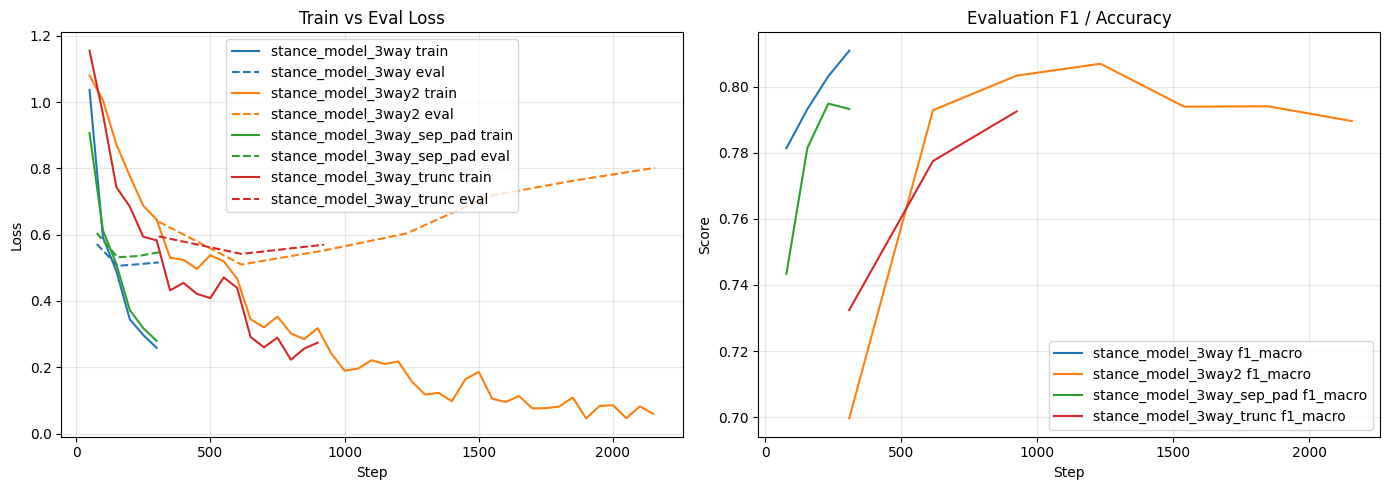

In [33]:
import os
import json
import matplotlib.pyplot as plt

model_root = "models"
model_dirs = [
    os.path.join(model_root, d)
    for d in os.listdir(model_root)
    if os.path.isdir(os.path.join(model_root, d))
]

model_logs = {}
for model_dir in model_dirs:
    state_path = os.path.join(model_dir, "trainer_state.json")
    if not os.path.exists(state_path):
        ckpts = [d for d in os.listdir(model_dir) if d.startswith("checkpoint")]
        if ckpts:
            ckpt_path = os.path.join(model_dir, ckpts[-1], "trainer_state.json")
            if os.path.exists(ckpt_path):
                state_path = ckpt_path
            else:
                continue
        else:
            continue

    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    logs = state["log_history"]
    model_name = os.path.basename(model_dir)
    model_logs[model_name] = logs

print(f"Found trainer states for {len(model_logs)} models: {list(model_logs.keys())}")

def extract_metrics(logs):
    steps, train_loss, eval_loss, eval_f1, eval_acc = [], [], [], [], []
    for entry in logs:
        step = entry.get("step")
        if "loss" in entry:
            steps.append(step)
            train_loss.append(entry["loss"])
        if "eval_loss" in entry:
            eval_loss.append((step, entry["eval_loss"]))
        if "eval_f1_macro" in entry:
            eval_f1.append((step, entry["eval_f1_macro"]))
        if "eval_accuracy" in entry:
            eval_acc.append((step, entry["eval_accuracy"]))
    return steps, train_loss, eval_loss, eval_f1, eval_acc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for i, (model_name, logs) in enumerate(model_logs.items()):
    steps, train_loss, eval_loss, eval_f1, eval_acc = extract_metrics(logs)

# loss
    axes[0].plot(steps, train_loss, color=colors[i % len(colors)], linestyle="-", label=f"{model_name} train")
    if eval_loss:
        eval_steps, eval_vals = zip(*eval_loss)
        axes[0].plot(eval_steps, eval_vals, color=colors[i % len(colors)], linestyle="--", label=f"{model_name} eval")
# acc
    if eval_f1:
        eval_steps, eval_vals = zip(*eval_f1)
        axes[1].plot(eval_steps, eval_vals, color=colors[i % len(colors)], linestyle="-", label=f"{model_name} f1_macro")
    elif eval_acc:
        eval_steps, eval_vals = zip(*eval_acc)
        axes[1].plot(eval_steps, eval_vals, color=colors[i % len(colors)], linestyle="--", label=f"{model_name} acc")

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlabel("Step")

axes[0].set_title("Train vs Eval Loss")
axes[0].set_ylabel("Loss")

axes[1].set_title("Evaluation F1 / Accuracy")
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()


Found trainer states for 4 models: ['stance_model_3way', 'stance_model_3way2', 'stance_model_3way_sep_pad', 'stance_model_3way_trunc']


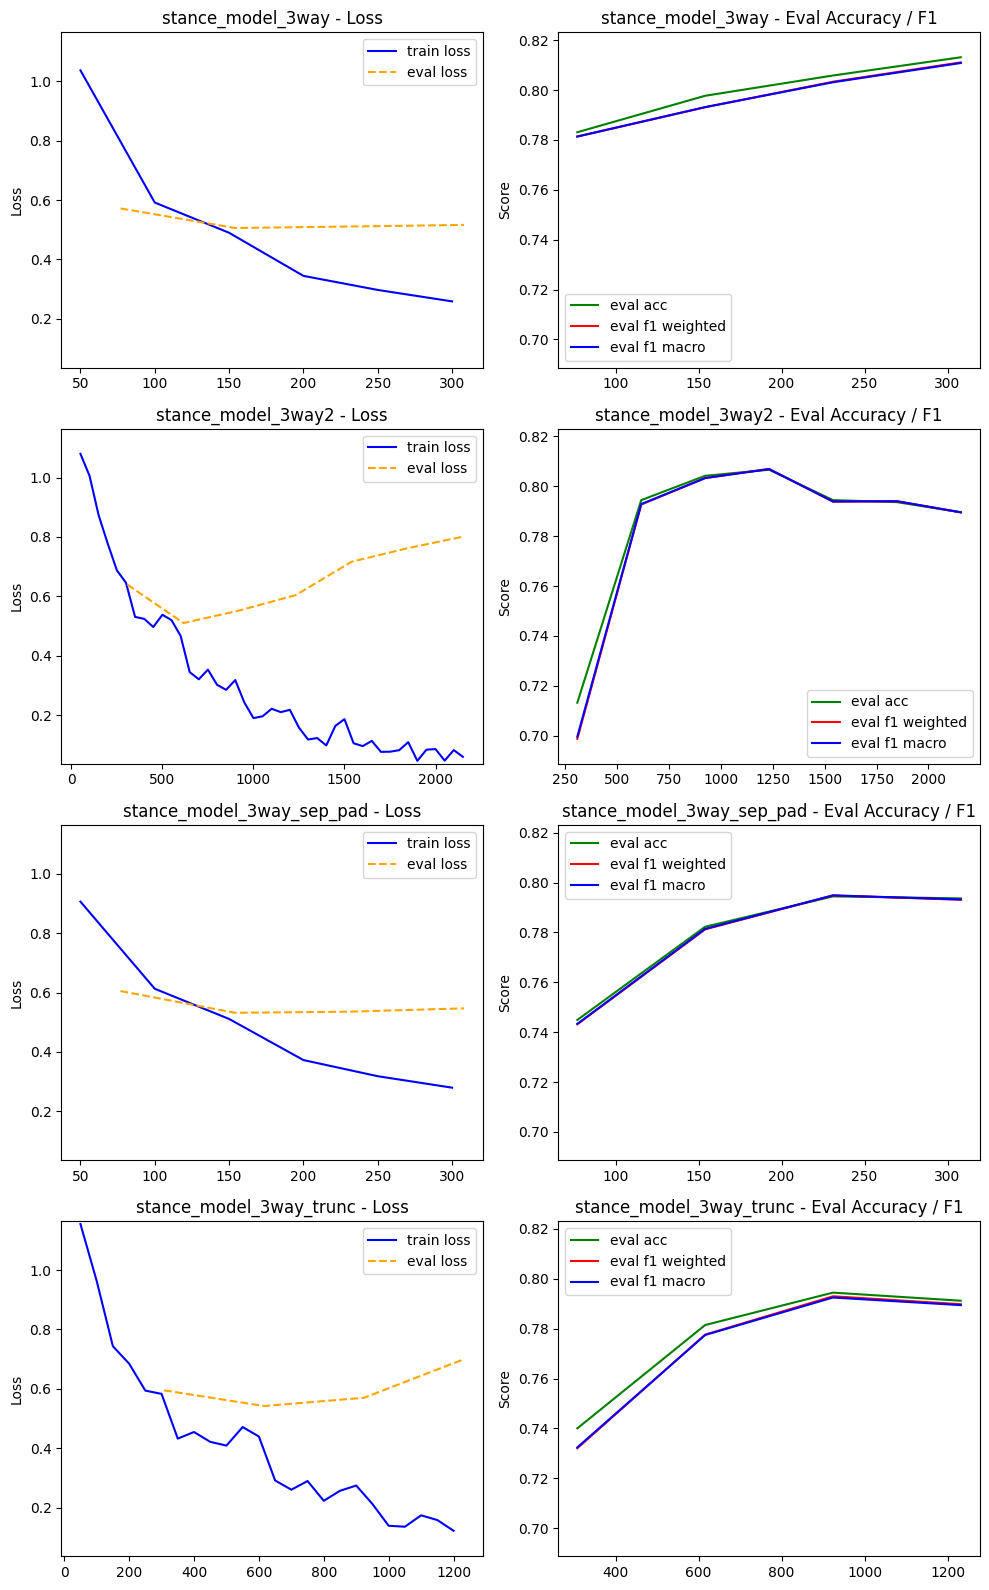

In [35]:
import os
import json
import matplotlib.pyplot as plt

model_root = "models"
model_dirs = [
    os.path.join(model_root, d)
    for d in os.listdir(model_root)
    if os.path.isdir(os.path.join(model_root, d))
]

model_logs = {}
for model_dir in model_dirs:
    state_path = os.path.join(model_dir, "trainer_state.json")
    if not os.path.exists(state_path):

        ckpts = [d for d in os.listdir(model_dir) if d.startswith("checkpoint")]
        if ckpts:
            ckpts.sort(key=lambda x: int(x.split("-")[-1]))  # 按 step 排序，取最新
            ckpt_path = os.path.join(model_dir, ckpts[-1], "trainer_state.json")
            if os.path.exists(ckpt_path):
                state_path = ckpt_path
            else:
                continue
        else:
            continue

    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    logs = state["log_history"]
    model_name = os.path.basename(model_dir)
    model_logs[model_name] = logs

print(f"Found trainer states for {len(model_logs)} models: {list(model_logs.keys())}")

parsed_logs = {}
for model_name, history in model_logs.items():
    steps = [x["step"] for x in history if "loss" in x]
    loss = [x["loss"] for x in history if "loss" in x]
    eval_steps = [x["step"] for x in history if "eval_loss" in x]
    eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
    eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
    eval_f1_weighted = [x["eval_f1_weighted"] for x in history if "eval_f1_weighted" in x]
    eval_f1_macro = [x["eval_f1_macro"] for x in history if "eval_f1_macro" in x]

    parsed_logs[model_name] = {
        "steps": steps,
        "loss": loss,
        "eval_steps": eval_steps,
        "eval_loss": eval_loss,
        "eval_acc": eval_acc,
        "eval_f1_weighted": eval_f1_weighted,
        "eval_f1_macro": eval_f1_macro,
    }

all_losses = [v for log in parsed_logs.values() for v in (log["loss"] + log["eval_loss"])]
loss_ylim = (min(all_losses)-0.01, max(all_losses)+0.01)

all_accs = []
for log in parsed_logs.values():
    all_accs += log["eval_acc"]
    all_accs += log["eval_f1_weighted"]
    all_accs += log["eval_f1_macro"]
acc_ylim = (min(all_accs)-0.01, max(all_accs)+0.01)

num_models = len(parsed_logs)
fig, axes = plt.subplots(num_models, 2, figsize=(10, 4 * num_models), sharey=False)

if num_models == 1:
    axes = [axes]

for i, (model_name, log) in enumerate(parsed_logs.items()):
    ax_loss, ax_acc = axes[i]

    # loss
    ax_loss.plot(log["steps"], log["loss"], label="train loss", color="blue")
    ax_loss.plot(log["eval_steps"], log["eval_loss"], label="eval loss", color="orange", linestyle="--")
    ax_loss.set_ylim(loss_ylim)
    ax_loss.set_title(f"{model_name} - Loss")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()

    # accuracy / f1
    if log["eval_acc"]:
        ax_acc.plot(log["eval_steps"], log["eval_acc"], label="eval acc", color="green")
    if log["eval_f1_weighted"]:
        ax_acc.plot(log["eval_steps"], log["eval_f1_weighted"], label="eval f1 weighted", color="red")
    if log["eval_f1_macro"]:
        ax_acc.plot(log["eval_steps"], log["eval_f1_macro"], label="eval f1 macro", color="blue")
    ax_acc.set_ylim(acc_ylim)
    ax_acc.set_title(f"{model_name} - Eval Accuracy / F1")
    ax_acc.set_ylabel("Score")
    ax_acc.legend()

plt.tight_layout()
plt.show()


### Inference Results Comparison
这里选取了同一个数据集下面不同主题的数据，原来用的是entertainment做微调，现在用culture看看纸面表现如何。可以看到acc和f1跟validation的表现差不多，说明立场分析对于这两个主题差异不大。

In [36]:
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score, classification_report

model_paths = [
    "models/stance_ch",
    "models/stance_model_3way_trunc",
    "models/stance_model_3way",
    "models/stance_model_3way_sep_pad",
    "models/stance_model_3way2"
]

dataset_path = "c-stance_culture"
N = 1000

dataset = load_from_disk(dataset_path)

test_data = dataset.select(range(min(N, len(dataset))))

def evaluate_model(model_path, dataset):
    print(f"\n=== Evaluating {model_path} ===")
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.eval()

    all_preds = []
    all_labels = []

    for target, text, label in zip(dataset["target"], dataset["text"], dataset["label"]):
        inputs = tokenizer(
            target,
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred = torch.argmax(probs, dim=-1).item()

        all_preds.append(pred)
        all_labels.append(label)


    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro',zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted',zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 (macro): {f1_macro:.4f}")
    print(f"F1 (weighted): {f1_weighted:.4f}")

    print("\n分类报告：")
    print(classification_report(
        all_labels, all_preds,
        target_names=["支持", "反对", "中立"],
        zero_division=0
    ))

    return {"acc": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

results = {}
for path in model_paths:
    results[path] = evaluate_model(path, test_data)

print("\n=== Summary ===")
for path, res in results.items():
    print(f"{path}:  acc={res['acc']:.4f},  f1_macro={res['f1_macro']:.4f},  f1_weighted={res['f1_weighted']:.4f}")



=== Evaluating models/stance_ch ===
Accuracy: 0.2740
F1 (macro): 0.2137
F1 (weighted): 0.2138

分类报告：
              precision    recall  f1-score   support

          支持       0.23      0.28      0.25       334
          反对       0.31      0.55      0.39       333
          中立       0.00      0.00      0.00       333

    accuracy                           0.27      1000
   macro avg       0.18      0.27      0.21      1000
weighted avg       0.18      0.27      0.21      1000


=== Evaluating models/stance_model_3way_trunc ===
Accuracy: 0.8370
F1 (macro): 0.8366
F1 (weighted): 0.8366

分类报告：
              precision    recall  f1-score   support

          支持       0.80      0.90      0.85       334
          反对       0.83      0.79      0.81       333
          中立       0.89      0.82      0.85       333

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000


=== Evaluating mode

In [41]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from data_processing import get_post, get_comments_and_replies
# 3-way classifier
model_path = "models/stance_ch"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

def predict_stance(post, comment, tokenizer, model):
    inputs = tokenizer(
        post,
        comment,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()

    labels = {0: "支持", 1: "反对", 2: "中立"}

    return {
        "stance": labels[predicted_class],
        "confidence": probs[0][predicted_class].item()
    }

def print_predictions(post, comment_list, tokenizer, model):
    print(f"Post: {post}")
    for comment in comment_list:
        result = predict_stance(post, comment, tokenizer, model)
        print(f"Comment: {comment}")
        print(f"立场: {result['stance']} (置信度: {result['confidence']:.4f})")

post = "姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。"
comments = [
    "怎么又是广告",
    "这家店我去过，感觉一般",
    "体验也很好"
]

def show_results(post, comments, model_path):
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.eval()
    print(f"Using {model_path}")
    print_predictions(post, comments, tokenizer, model)

# post = get_post("weibo2.json")
# comments=get_comments_and_replies("weibo2.json")
print(f"Using {model_path}")
print_predictions(post, comments, tokenizer, model)


Using models/stance_ch
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
立场: 支持 (置信度: 0.6545)
Comment: 这家店我去过，感觉一般
立场: 反对 (置信度: 0.5640)
Comment: 体验也很好
立场: 反对 (置信度: 0.7566)


In [42]:
model_path = "models/stance_model_3way_trunc"
print(f"Using {model_path}")
show_results(post, comments, model_path)

Using models/stance_model_3way_trunc
Using models/stance_model_3way_trunc
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
立场: 中立 (置信度: 0.9329)
Comment: 这家店我去过，感觉一般
立场: 反对 (置信度: 0.6763)
Comment: 体验也很好
立场: 支持 (置信度: 0.5374)


In [38]:
model_path = "models/stance_model_3way"
print(f"Using {model_path}")
show_results(post, comments, model_path)

Using models/stance_model_3way
Using models/stance_model_3way
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
立场: 中立 (置信度: 0.6705)
Comment: 这家店我去过，感觉一般
立场: 反对 (置信度: 0.7007)
Comment: 体验也很好
立场: 反对 (置信度: 0.5093)


In [39]:
model_path = "models/stance_model_3way_sep_pad"
print(f"Using {model_path}")
show_results(post, comments, model_path)

Using models/stance_model_3way_sep_pad
Using models/stance_model_3way_sep_pad
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
立场: 中立 (置信度: 0.6239)
Comment: 这家店我去过，感觉一般
立场: 反对 (置信度: 0.8773)
Comment: 体验也很好
立场: 反对 (置信度: 0.6533)


In [40]:
model_path = "models/stance_model_3way2"
print(f"Using {model_path}")
show_results(post, comments, model_path)

Using models/stance_model_3way2
Using models/stance_model_3way2
Post: 姐妹们，这家店的服务真的太好了，而且还不贵，就在地铁站旁边。
Comment: 怎么又是广告
立场: 中立 (置信度: 0.6939)
Comment: 这家店我去过，感觉一般
立场: 反对 (置信度: 0.9533)
Comment: 体验也很好
立场: 支持 (置信度: 0.8607)


## Fine-tune a Binary Stance Detection Model
可能三分类还是有点复杂了，现在我们把“中立”的标签过滤出去，只保留“支持”和“反对”。原来三分类的数据是6153个（train4922+val1231），去掉“中立”后是

In [43]:
df_clauses_binary=df_clauses[df_clauses["label"].isin([0,1])].copy()
#{"支持": 0, "反对": 1, "中立": 2}
df_clauses_binary

,text,target,label
0,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,每次看电影只看自己感兴趣的,0
1,感觉每打开一部电影，看了一小段开头后就没什么耐心，就拿起手机干别的事。而且每次都只会看自己感...,看了自己喜欢的电影，阅片量没长进，不是自己的问题，主要原因还是电影内容不够丰富生动,1
3,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍是人类进步的阶梯,0
4,当我决定写奥尔巴赫摹仿论，我随即打开小红书在宿舍扒完了妈妈木和女娃。都说书籍是人类进步的阶梯...,书籍并非人类进步阶梯，有的书籍是糟粕，是阻碍人类进步的绊脚石,1
6,“小时候不理解老人晒太阳，一坐就是半天。长大了才明白，目之所及皆是回忆，心之所想皆是过往，眼...,眼之所看皆是遗憾,0
...,...,...,...
6145,原油 原油周一先跌后反弹，下跌70.2未下破70开始震荡上行，最高到达73.9，日线结束6连...,油价是不会下跌的，它将会保持一个平稳的价格，不会改变。,1
6147,国际原油 这轮油价的调整幅度比预期要大，跌至 70水平，将今年全部涨幅回吐出来，回到原点，显...,国际原油现在是属于合理的水平。未来跌的空间也是有限的。,0
6148,国际原油 这轮油价的调整幅度比预期要大，跌至 70水平，将今年全部涨幅回吐出来，回到原点，显...,油价一天一个价，怎么可能像你说的那样准确，都是忽悠人的吧。,1
6150,2017年，我开车在高速路上，突然看到没油了，下高速跑了好几个加油站，才加到适合我的车的标号...,国内油价普遍比国外的都要高。,0


In [44]:
from datasets import Dataset
ds_bin=Dataset.from_pandas(df_clauses_binary)
ds_bin=ds_bin.train_test_split(test_size=0.2)
# ds_bin.save_to_disk("c-stance_entertainment_bin")
ds_bin

Saving the dataset (0/1 shards):   0%|          | 0/3281 [00:00<?, ? examples/s]

OSError: [Errno 22] Invalid argument: 'C:/Users/28177/mini_nlp_projects/social_media_stance_detection/c-stance_entertainment_bin/train/data-00000-of-00001.arrow'